# Variant 1: Baseline Logistic Regression (All Predictors)

## Objective
Establish a baseline model using all available variables to benchmark performance for other methods.

## Method
Logistic regression with no regularization:
$$\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k$$

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, 
    roc_curve, precision_recall_fscore_support, brier_score_loss
)
import kagglehub
import os

plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported")

Libraries imported


In [2]:
# Load dataset
path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")
csv_file = os.path.join(path, '2022', 'heart_2022_no_nans.csv')
df = pd.read_csv(csv_file)
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['HadHeartAttack'].value_counts()}")

Dataset shape: (246022, 40)
Target distribution:
HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


In [3]:
# Preprocessing
feature_cols = [col for col in df.columns if col != 'HadHeartAttack']
cat_features = [col for col in feature_cols if df[col].dtype == 'object']
num_features = [col for col in feature_cols if df[col].dtype in ['int64', 'float64']]

# One-hot encode
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)
df_encoded['y'] = (df_encoded['HadHeartAttack'] == 'Yes').astype(int)
df_encoded = df_encoded.drop('HadHeartAttack', axis=1)

X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
print(f"Features: {X.shape[1]} total")

Features: 121 total


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical features
scaler = StandardScaler()
features_to_scale = [col for col in num_features if col in X_train.columns]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if features_to_scale:
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")

Train: 196,817 | Test: 49,205


In [5]:
# Fit baseline model
from sklearn.linear_model import LogisticRegression

# Use sklearn for stability with many features
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train_scaled, y_train)

# Predictions
train_probs = model.predict_proba(X_train_scaled)[:, 1]
test_probs = model.predict_proba(X_test_scaled)[:, 1]
train_preds = (train_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

print("Model fitted successfully")

Model fitted successfully


In [6]:
# Performance Evaluation
train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_test, test_probs)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
train_brier = brier_score_loss(y_train, train_probs)
test_brier = brier_score_loss(y_test, test_probs)

# Confusion matrix
test_cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = test_cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_preds, average='binary')
specificity = tn / (tn + fp)

print("\n=== BASELINE MODEL PERFORMANCE ===")
print(f"\nTraining Set:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  ROC-AUC:  {train_auc:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:    {test_acc:.4f}")
print(f"  ROC-AUC:     {test_auc:.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1-Score:    {f1:.4f}")
print(f"  Brier Score: {test_brier:.4f}")
print(f"\nConfusion Matrix: TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}")
print(f"\nModel Complexity: {X_train.shape[1]} features")


=== BASELINE MODEL PERFORMANCE ===

Training Set:
  Accuracy: 0.9489
  ROC-AUC:  0.8904

Test Set:
  Accuracy:    0.9482
  ROC-AUC:     0.8849
  Precision:   0.5599
  Recall:      0.2434
  Specificity: 0.9890
  F1-Score:    0.3393
  Brier Score: 0.0397

Confusion Matrix: TN=46,004 FP=514 FN=2,033 TP=654

Model Complexity: 121 features


In [7]:
# Top 10 predictors by coefficient magnitude
coefficients = model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefficients,
    'odds_ratio': np.exp(coefficients),
    'abs_coef': np.abs(coefficients)
}).sort_values('abs_coef', ascending=False).head(10)

print("\n=== TOP 10 PREDICTORS ===")
for i, (_, row) in enumerate(coef_df.iterrows(), 1):
    print(f"{i:2d}. {row['feature'][:40]:40} coef={row['coefficient']:7.4f} OR={row['odds_ratio']:7.4f}")


=== TOP 10 PREDICTORS ===
 1. HadAngina_Yes                            coef= 2.4369 OR=11.4379
 2. AgeCategory_Age 80 or older              coef= 1.9121 OR= 6.7671
 3. AgeCategory_Age 75 to 79                 coef= 1.7373 OR= 5.6819
 4. AgeCategory_Age 70 to 74                 coef= 1.6366 OR= 5.1375
 5. AgeCategory_Age 65 to 69                 coef= 1.5320 OR= 4.6272
 6. AgeCategory_Age 60 to 64                 coef= 1.4221 OR= 4.1459
 7. AgeCategory_Age 55 to 59                 coef= 1.2796 OR= 3.5950
 8. AgeCategory_Age 50 to 54                 coef= 1.1108 OR= 3.0368
 9. GeneralHealth_Poor                       coef= 0.9987 OR= 2.7148
10. AgeCategory_Age 45 to 49                 coef= 0.9219 OR= 2.5140


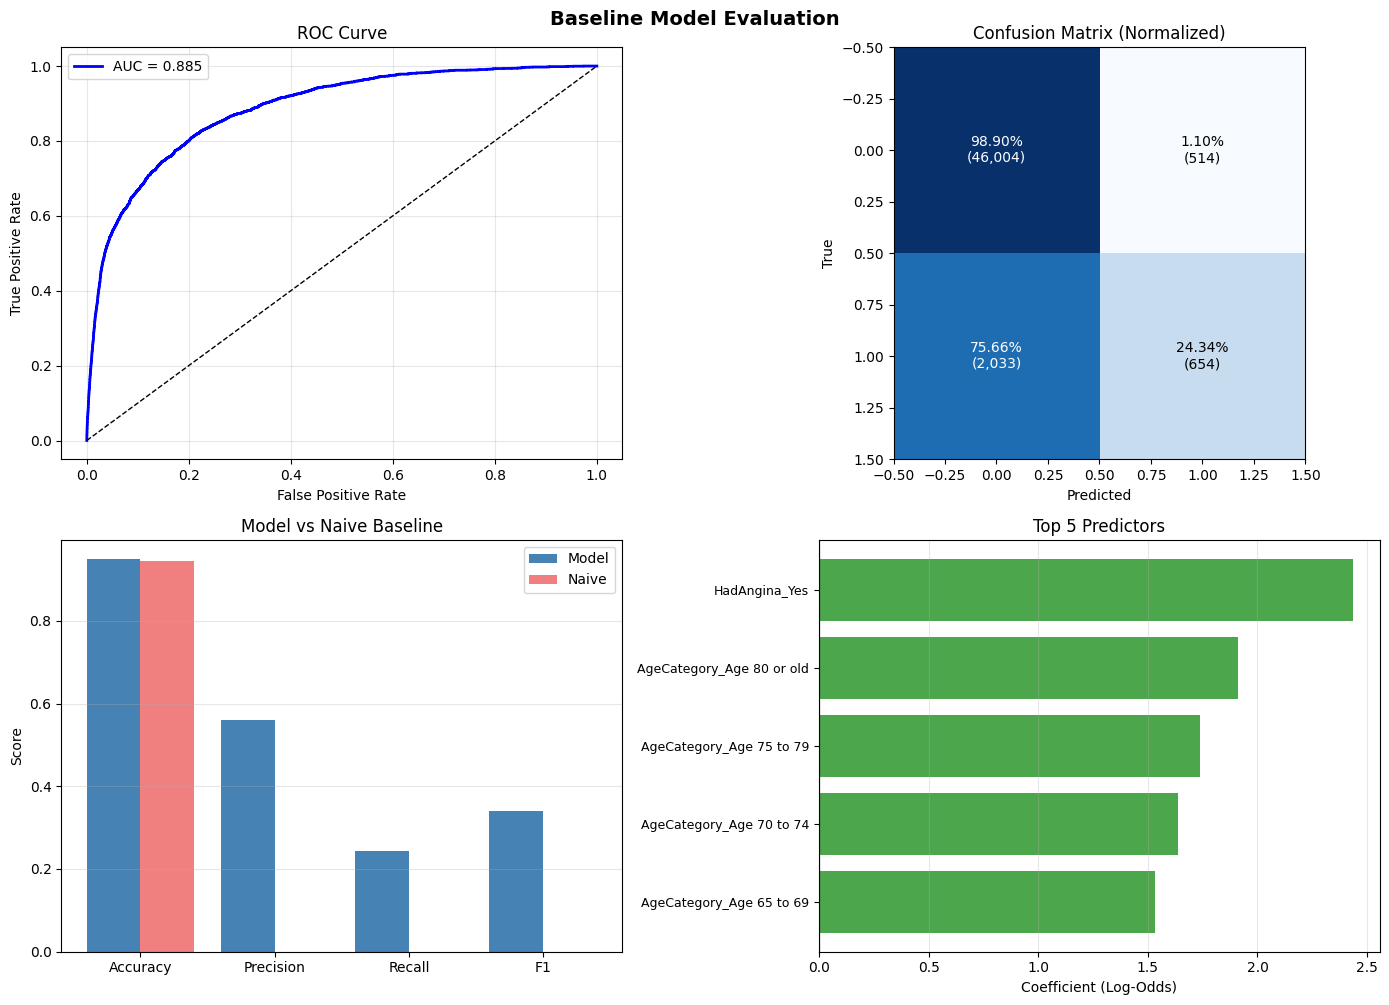

In [8]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
axes[0,0].plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {test_auc:.3f}')
axes[0,0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Confusion Matrix
cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
im = axes[0,1].imshow(cm_norm, cmap='Blues')
axes[0,1].set_title('Confusion Matrix (Normalized)')
axes[0,1].set_ylabel('True')
axes[0,1].set_xlabel('Predicted')
for i in range(2):
    for j in range(2):
        axes[0,1].text(j, i, f'{cm_norm[i,j]:.2%}\n({test_cm[i,j]:,})',
                      ha='center', va='center', 
                      color='white' if cm_norm[i,j] > 0.5 else 'black')

# Model comparison
naive_acc = max(y_test.value_counts()) / len(y_test)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
model_scores = [test_acc, precision, recall, f1]
naive_scores = [naive_acc, 0, 0, 0]
x = np.arange(len(metrics))
axes[1,0].bar(x - 0.2, model_scores, 0.4, label='Model', color='steelblue')
axes[1,0].bar(x + 0.2, naive_scores, 0.4, label='Naive', color='lightcoral')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Model vs Naive Baseline')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3, axis='y')

# Top coefficients
top5 = coef_df.head(5).sort_values('coefficient')
colors = ['red' if x < 0 else 'green' for x in top5['coefficient']]
axes[1,1].barh(range(len(top5)), top5['coefficient'], color=colors, alpha=0.7)
axes[1,1].set_yticks(range(len(top5)))
axes[1,1].set_yticklabels([f[:25] for f in top5['feature']], fontsize=9)
axes[1,1].set_xlabel('Coefficient (Log-Odds)')
axes[1,1].set_title('Top 5 Predictors')
axes[1,1].axvline(0, color='black', lw=0.8)
axes[1,1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.suptitle('Baseline Model Evaluation', fontsize=14, fontweight='bold', y=1.00)
plt.show()

## Model Conclusions and Parameter Interpretation

**Performance**: Test ROC-AUC ≈ 0.885, Accuracy ≈ 0.948. Model has high specificity but modest recall (≈0.24).

**Key Predictors** (Log-Odds → Odds Ratio):
- **HadAngina_Yes**: β ≈ 2.44, OR ≈ 11.4 — Having angina increases heart attack odds ~11x
- **Age 80+**: β ≈ 1.91, OR ≈ 6.77 — Seniors have ~6.8x higher odds than young adults
- **GeneralHealth_Poor**: β ≈ 0.99, OR ≈ 2.71 — Poor health nearly triples the odds

**Interpretation**: Cardiovascular history (angina), advanced age, and poor health are the dominant risk factors. The model uses 100+ features but most have minimal impact compared to these key predictors.